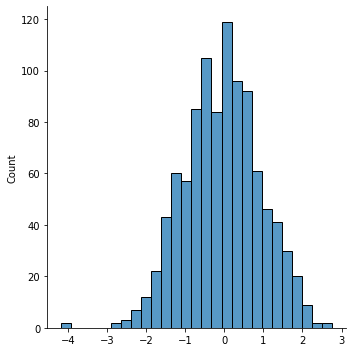

In [1]:
import numpy as np
noise_test = np.random.normal(0,1,1000)
import seaborn as sns
sns.displot(noise_test)

In [2]:
np.random.seed(123)
import matplotlib.pyplot as plt

In [3]:
nb_samples = 1000
X = np.zeros((nb_samples,2))
Y = np.zeros(nb_samples)
for i in range(0,nb_samples,4):
  noise = np.random.normal(0,1,8)
  X[i],    Y[i]   = (-2+noise[0], -2+noise[1]), 0
  X[i+1],  Y[i+1] = ( 2+noise[2], -2+noise[3]), 1
  X[i+2],  Y[i+2] = (-2+noise[4],  2+noise[5]), 1
  X[i+3],  Y[i+3] = ( 2+noise[6],  2+noise[7]), 0

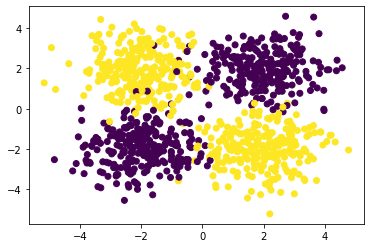

In [4]:
fig1=plt.figure()
plt.scatter(X[:,0], X[:,1], c=Y[:])

In [5]:
np.random.permutation(10)

array([4, 7, 8, 5, 6, 0, 1, 2, 3, 9])

In [6]:
def activation(x):
  return 1 / (1+np.exp(-x))

def dactivation(x):
  return np.exp(-x) / ((1+np.exp(-x))**2)

In [10]:
class MLP: # multi layer perceptron
  def __init__(self, *args): # konstruktor
    self.shape = args # neuronhalo felepitese
    n = len(args) # retegek szama
    self.layers = []
    self.layers.append(np.ones(self.shape[0]+1)) # +1 a bias
    for i in range(1,n):
      self.layers.append(np.ones(self.shape[i])) # a 
    self.weights = []
    for i in range(n-1):
      self.weights.append(np.zeros((self.layers[i].size,
                                    self.layers[i+1].size)))
    
    
    self.reset()
    #HF2 initialization for momentum
    self.v_weights = []
    for i in range(n-1):
      self.v_weights.append(np.zeros((self.layers[i].size,
                                   self.layers[i+1].size)))
    #HF2 initialization for momentum end

  def reset(self):
    for i in range((len(self.weights))):
      Z = np.random.random((self.layers[i].size, 
                            self.layers[i+1].size)) # [0,1)
      self.weights[i][...] = (2*Z-1)*1 # [-1,1)

  def propagate_forward(self, data):
    self.layers[0][0:-1] = data # utolso a bias
    for i in range(1, len(self.shape)):
      self.layers[i][...] = activation(np.dot(self.layers[i-1], self.weights[i-1]))
    return self.layers[-1] # y_kalap
  
  #HF2 setting up the parameters for the momentum, l1reg, l2reg
  def propagate_backward(self, target, lr=0.1, momentum_beta = 0, l1_lambda = 0, l2_lambda = 0):
    error = -(target - self.layers[-1])
    delta = np.multiply(error,dactivation(np.dot(self.layers[-2], self.weights[-1])))
    deltas = []
    deltas.append(delta)
    # gradiensek kiszamitasa
    for i in range(len(self.shape)-2, 0, -1): # 3
      delta = np.dot(deltas[0],self.weights[i].T)*dactivation(np.dot(self.layers[i-1], self.weights[i-1]))
      deltas.insert(0,delta)
    # sulyok modositasa
    for i in range(len(self.weights)):
      layer = np.atleast_2d(self.layers[i]) ### 
      delta = np.atleast_2d(deltas[i]) ##
      #HF2 start l1reg
      #calculating the l1 factor,the formula comes from the presentation slides
      l1 = lr*l1_lambda*np.sign(self.weights[i])
      #HF2 end l1reg
      #HF2 start l2reg
      #calculating the l2 factor,the formula comes from the presentation slides
      l2 = lr*l2_lambda*self.weights[i]
      #HF2 end l2reg
      #HF2 start momentum
      #updating the "velocity" (in the presentation called deltaW)
      self.v_weights[i] = momentum_beta*self.v_weights[i] - lr*np.dot(layer.T, delta)
      #updating the weights according to the "velocity" and l1reg l2reg
      self.weights[i] += self.v_weights[i] - l1 - l2
      #HF2 end momentum
    return (error**2).sum()

In [11]:
def learn(network, X, Y, valid_split=0.2, test_split=0.1, epochs=20, lrate=0.1):
  v_start = int(nb_samples*(1-valid_split-test_split))
  t_start = int(nb_samples*(1-test_split))
  X_train, Y_train = X[:v_start],        Y[:v_start]
  X_valid, Y_valid = X[v_start:t_start], Y[v_start:t_start]
  X_test , Y_test  = X[t_start:],        Y[t_start:]

  randperm = np.random.permutation(len(X_train))
  X_train, Y_train = X_train[randperm], Y_train[randperm]

  for i in range(epochs):
    # TANITAS
    train_err = 0
    for k in range(X_train.shape[0]):
        # forward lepes
        neural_net.propagate_forward(X_train[k])
        # backward lepes
        sample_err = neural_net.propagate_backward( Y_train[k], lrate)
        train_err += sample_err
    # train_err normalasa
    train_err /= X_train.shape[0]
    # VALIDALAS
    valid_err = 0
    o_valid = np.zeros(X_valid.shape[0])
    for k in range(X_valid.shape[0]):
      # forward lepes
      o_valid[k] = neural_net.propagate_forward(X_valid[k])
      # hiba szamitas a forward lepesbol keletkezo predikciokbol
      sample_err = (Y_valid[k]-o_valid[k])**2
      valid_err += sample_err
    valid_err /= X_valid.shape[0]
    
    print("{}. epoch\ttrain error: {}\tvalid error: {}".format(i,np.round(train_err,3),np.round(valid_err,3)))

  ## Teszteles
  test_err = 0
  o_test = np.zeros(X_test.shape[0])
  for k in range(X_test.shape[0]):
    # forward lepes
    o_test[k] = neural_net.propagate_forward(X_test[k])
    # hiba szamitas
    sample_err = (Y_test[k]-o_test[k])**2
    test_err += sample_err
    print("True value: {}\tPredicted value: {}\tInput:{},{}".format(Y_test[k],o_test[k],X_test[k,0],X_test[k,1]))
  test_err /= X_test.shape[0]
  print("Test error: {}".format(test_err))
  
  # vizualizalas...
  fig1=plt.figure()
  plt.scatter(X_test[:,0], X_test[:,1], c=np.round(o_test[:]))


0. epoch	train error: 0.236	valid error: 0.224
1. epoch	train error: 0.211	valid error: 0.194
2. epoch	train error: 0.18	valid error: 0.163
3. epoch	train error: 0.151	valid error: 0.137
4. epoch	train error: 0.129	valid error: 0.119
5. epoch	train error: 0.113	valid error: 0.105
6. epoch	train error: 0.101	valid error: 0.095
7. epoch	train error: 0.091	valid error: 0.087
8. epoch	train error: 0.084	valid error: 0.082
9. epoch	train error: 0.079	valid error: 0.077
10. epoch	train error: 0.075	valid error: 0.074
11. epoch	train error: 0.071	valid error: 0.072
12. epoch	train error: 0.069	valid error: 0.069
13. epoch	train error: 0.066	valid error: 0.068
14. epoch	train error: 0.064	valid error: 0.066
15. epoch	train error: 0.063	valid error: 0.065
16. epoch	train error: 0.061	valid error: 0.064
17. epoch	train error: 0.06	valid error: 0.063
18. epoch	train error: 0.059	valid error: 0.062
19. epoch	train error: 0.057	valid error: 0.062
20. epoch	train error: 0.056	valid error: 0.061
21. 

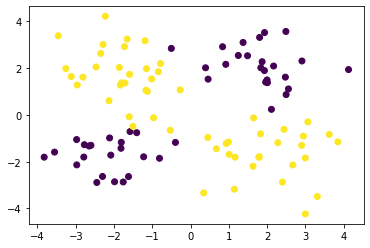

In [12]:
np.random.seed(100)
neural_net = MLP(2,3,1)
learn(neural_net, X, Y, epochs=150, lrate=0.1)